In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("../..")
%matplotlib inline

In [2]:
from processor.preprocessors import data_split
from trading_env.env_cryptotrading_v1 import CryptoTradingEnv
from agent.models import DRLAgent
from config import (
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    VALID_2_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from stable_baselines3.common.logger import configure

In [3]:
state_interval = 5
TEST_START_DATE = pd.to_datetime(TEST_START_DATE)
TEST_START_DATE = TEST_START_DATE - pd.Timedelta(hours=state_interval - 1)
TEST_START_DATE = TEST_START_DATE.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
processed_dts10_add_tech = pd.read_csv("../../dataset/hour-level/crypto_TI_t10_2023-04-01.csv")

In [5]:
train = data_split(processed_dts10_add_tech, TRAIN_START_DATE, VALID_2_END_DATE)
valid = data_split(processed_dts10_add_tech, TEST_START_DATE, TEST_END_DATE)
print(len(train))
print(len(valid))

175190
21640


In [6]:
crypto_tic_dim = len(train.tic.unique())
# state_space_dim = 1 + 2*crypto_tic_dim + len(INDICATORS)*crypto_tic_dim
state_space_dim = 1 + (state_interval * 5 + 1) * crypto_tic_dim
print(f"Stock Dimension: {crypto_tic_dim}, State Space: {state_space_dim}")

Stock Dimension: 10, State Space: 261


## Agents

### PPO

In [7]:
buy_cost_list = sell_cost_list = [0.001] * crypto_tic_dim
num_stock_shares = [0] * crypto_tic_dim

env_kwargs_train = {
    "cash": 100000,
    "action_scaling": 1/10,
    "num_crypto_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space_dim": state_space_dim,
    "crypto_dim": crypto_tic_dim,
    "action_space_dim": crypto_tic_dim,
    "print_verbosity": 5,
    "eval_time_interval": 30 * 24,
    "is_debug": False,
    "risk_control": False,
    "model_name": "ppo_hour_level",
    "data_granularity": 24,
    "state_interval": state_interval
}
env_kwargs_test = env_kwargs_train.copy()
env_kwargs_test["is_debug"] = False

In [8]:
e_train_gym = CryptoTradingEnv(df = train, **env_kwargs_train)
e_valid_gym = CryptoTradingEnv(df = valid, **env_kwargs_test)

In [9]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.001,
    "batch_size": 256
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS, seed=42)
# set up logger
tmp_path = RESULTS_DIR + '/ppo_hour_level'
new_logger_ppo = configure(tmp_path, ["csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 256}
Using cuda device


In [10]:
final = []
iterations = 30
max_account_value = 0

for i in range(iterations):
    # train model
    trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=100000)
    df_account_value_ppo, df_actionppo, df_valid_actionppo, df_stateppo = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_valid_gym)
    res = df_account_value_ppo["portfolio_value"][len(df_account_value_ppo)-1]
    final.append(df_account_value_ppo["portfolio_value"])
    df_account_value_ppo.to_csv(f"../../plot/dataset/ppo_hourly_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_pnl_reward.csv")
    trained_ppo.save(f"../../model_saves/ppo_hourly_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_pnl_reward")


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 5
begin_portfolio_value:	 99979.41
end_portfolio_value:	 3403.00
total_profits:		 -96576.41
total_buy_cost:		 170205.83
total_sell_cost:	 170446.48
total_buy_trades:	 36061
total_sell_trades:	 45333

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 10
begin_portfolio_value:	 99954.94
end_portfolio_value:	 8135.59
total_profits:		 -91819.34
total_buy_cost:		 215229.96
total_sell_cost:	 215561.87
total_buy_trades:	 28815
total_sell_trades:	 35646

episode:		 5
begin_portfolio_value:	 99972.99
end_portfolio_value:	 113072.55
total_profits:		 13099.56
total_buy_cost:		 7262.19
total_sell_cost:	 7176.63
total_buy_trades:	 1526
total_sell_trades:	 2037

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 15
begin_portfolio_value:	 99930.07
end_portfolio_value:	 9460.73
total_profits:		 -90469.34
total_buy_cost:		 194031.01
total_sell_cost:	 194319.36
total_buy_trades:	 23793
total_sell_trades:	 29330

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 20
begin_portfolio_value:	 99938.42
end_portfolio_value:	 7512.95
total_profits:		 -92425.47
total_buy_cost:		 128344.13
total_sell_cost:	 128502.02
total_buy_trades:	 20651
total_sell_trades:	 24670

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 30
begin_portfolio_value:	 99924.32
end_portfolio_value:	 8929.41
total_profits:		 -90994.91
total_buy_cost:		 150861.07
total_sell_cost:	 151063.00
total_buy_trades:	 22171
total_sell_trades:	 25756

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 35
begin_portfolio_value:	 99924.78
end_portfolio_value:	 4967.50
total_profits:		 -94957.28
total_buy_cost:		 165066.63
total_sell_cost:	 165296.99
total_buy_trades:	 23589
total_sell_trades:	 27040

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 40
begin_portfolio_value:	 99938.11
end_portfolio_value:	 1604.18
total_profits:		 -98333.92
total_buy_cost:		 124444.33
total_sell_cost:	 124593.37
total_buy_trades:	 26992
total_sell_trades:	 30472

episode:		 20
begin_portfolio_value:	 99945.69
end_portfolio_value:	 113183.91
total_profits:		 13238.22
total_buy_cost:		 8908.31
total_sell_cost:	 8826.05
total_buy_trades:	 1302
total_sell_trades:	 1537

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 45
begin_portfolio_value:	 99952.44
end_portfolio_value:	 4277.73
total_profits:		 -95674.71
total_buy_cost:		 188285.10
total_sell_cost:	 188563.19
total_buy_trades:	 28111
total_sell_trades:	 31784

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 50
begin_portfolio_value:	 99940.06
end_portfolio_value:	 679.07
total_profits:		 -99260.99
total_buy_cost:		 167221.12
total_sell_cost:	 167455.80
total_buy_trades:	 34790
total_sell_trades:	 39197

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 60
begin_portfolio_value:	 99970.03
end_portfolio_value:	 472.02
total_profits:		 -99498.01
total_buy_cost:		 131742.04
total_sell_cost:	 131905.68
total_buy_trades:	 36943
total_sell_trades:	 41001

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 65
begin_portfolio_value:	 99943.04
end_portfolio_value:	 1052.02
total_profits:		 -98891.01
total_buy_cost:		 208769.36
total_sell_cost:	 209087.22
total_buy_trades:	 37908
total_sell_trades:	 41794

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 70
begin_portfolio_value:	 99943.88
end_portfolio_value:	 1085.93
total_profits:		 -98857.94
total_buy_cost:		 223866.61
total_sell_cost:	 224214.70
total_buy_trades:	 35672
total_sell_trades:	 38881

episode:		 35
begin_portfolio_value:	 99960.04
end_portfolio_value:	 101070.45
total_profits:		 1110.41
total_buy_cost:		 21226.44
total_sell_cost:	 21168.83
total_buy_trades:	 2384
total_sell_trades:	 2633

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 75
begin_portfolio_value:	 99960.04
end_portfolio_value:	 587.68
total_profits:		 -99372.36
total_buy_cost:		 308407.27
total_sell_cost:	 308924.81
total_buy_trades:	 35511
total_sell_trades:	 38763

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 80
begin_portfolio_value:	 99960.04
end_portfolio_value:	 424.26
total_profits:		 -99535.78
total_buy_cost:		 157624.42
total_sell_cost:	 157839.88
total_buy_trades:	 33266
total_sell_trades:	 36260

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 90
begin_portfolio_value:	 99950.05
end_portfolio_value:	 4950.30
total_profits:		 -94999.75
total_buy_cost:		 249110.89
total_sell_cost:	 249509.52
total_buy_trades:	 24725
total_sell_trades:	 26845

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 95
begin_portfolio_value:	 99930.07
end_portfolio_value:	 11087.58
total_profits:		 -88842.49
total_buy_cost:		 485117.06
total_sell_cost:	 485988.16
total_buy_trades:	 22175
total_sell_trades:	 23960

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 100
begin_portfolio_value:	 99960.04
end_portfolio_value:	 43929.78
total_profits:		 -56030.26
total_buy_cost:		 1111327.65
total_sell_cost:	 1113452.43
total_buy_trades:	 19009
total_sell_trades:	 20385

episode:		 50
begin_portfolio_value:	 99947.92
end_portfolio_value:	 137494.32
total_profits:		 37546.40
total_buy_cost:		 14496.49
total_sell_cost:	 14425.41
total_buy_trades:	 1254
total_sell_trades:	 1316

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 105
begin_portfolio_value:	 99940.06
end_portfolio_value:	 17871.78
total_profits:		 -82068.28
total_buy_cost:		 365532.20
total_sell_cost:	 366163.90
total_buy_trades:	 15593
total_sell_trades:	 16609

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 110
begin_portfolio_value:	 99940.06
end_portfolio_value:	 11432.79
total_profits:		 -88507.27
total_buy_cost:		 484100.84
total_sell_cost:	 484969.91
total_buy_trades:	 22733
total_sell_trades:	 24323

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 120
begin_portfolio_value:	 99960.04
end_portfolio_value:	 7286.80
total_profits:		 -92673.24
total_buy_cost:		 365614.12
total_sell_cost:	 366245.98
total_buy_trades:	 23850
total_sell_trades:	 25544

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 125
begin_portfolio_value:	 99936.88
end_portfolio_value:	 8208.92
total_profits:		 -91727.96
total_buy_cost:		 255136.23
total_sell_cost:	 255546.91
total_buy_trades:	 20772
total_sell_trades:	 22167

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 130
begin_portfolio_value:	 99949.99
end_portfolio_value:	 2475.00
total_profits:		 -97474.99
total_buy_cost:		 208082.29
total_sell_cost:	 208398.78
total_buy_trades:	 23223
total_sell_trades:	 24764

episode:		 65
begin_portfolio_value:	 99950.05
end_portfolio_value:	 123193.54
total_profits:		 23243.49
total_buy_cost:		 3268.09
total_sell_cost:	 3174.53
total_buy_trades:	 366
total_sell_trades:	 363

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 135
begin_portfolio_value:	 99940.06
end_portfolio_value:	 6274.15
total_profits:		 -93665.91
total_buy_cost:		 249258.69
total_sell_cost:	 249657.61
total_buy_trades:	 19902
total_sell_trades:	 21006

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 140
begin_portfolio_value:	 99969.49
end_portfolio_value:	 2989.80
total_profits:		 -96979.70
total_buy_cost:		 283741.40
total_sell_cost:	 284209.35
total_buy_trades:	 23699
total_sell_trades:	 25045

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 150
begin_portfolio_value:	 99950.05
end_portfolio_value:	 1292.19
total_profits:		 -98657.86
total_buy_cost:		 262767.18
total_sell_cost:	 263193.14
total_buy_trades:	 28060
total_sell_trades:	 29933

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 155
begin_portfolio_value:	 99950.05
end_portfolio_value:	 3760.20
total_profits:		 -96189.85
total_buy_cost:		 278519.56
total_sell_cost:	 278977.05
total_buy_trades:	 26874
total_sell_trades:	 28709

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 160
begin_portfolio_value:	 99940.06
end_portfolio_value:	 9027.82
total_profits:		 -90912.24
total_buy_cost:		 595023.83
total_sell_cost:	 596114.97
total_buy_trades:	 22609
total_sell_trades:	 24281

episode:		 80
begin_portfolio_value:	 99954.36
end_portfolio_value:	 133557.30
total_profits:		 33602.94
total_buy_cost:		 13204.82
total_sell_cost:	 13131.16
total_buy_trades:	 1338
total_sell_trades:	 1418

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 165
begin_portfolio_value:	 99930.07
end_portfolio_value:	 16668.66
total_profits:		 -83261.41
total_buy_cost:		 469837.88
total_sell_cost:	 470678.39
total_buy_trades:	 19738
total_sell_trades:	 21148

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 170
begin_portfolio_value:	 99950.05
end_portfolio_value:	 79717.42
total_profits:		 -20232.63
total_buy_cost:		 683593.79
total_sell_cost:	 684862.24
total_buy_trades:	 12955
total_sell_trades:	 13736

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 180
begin_portfolio_value:	 99940.06
end_portfolio_value:	 103397.02
total_profits:		 3456.96
total_buy_cost:		 551939.18
total_sell_cost:	 552944.06
total_buy_trades:	 8509
total_sell_trades:	 8963

hit end!


# Backtesting results

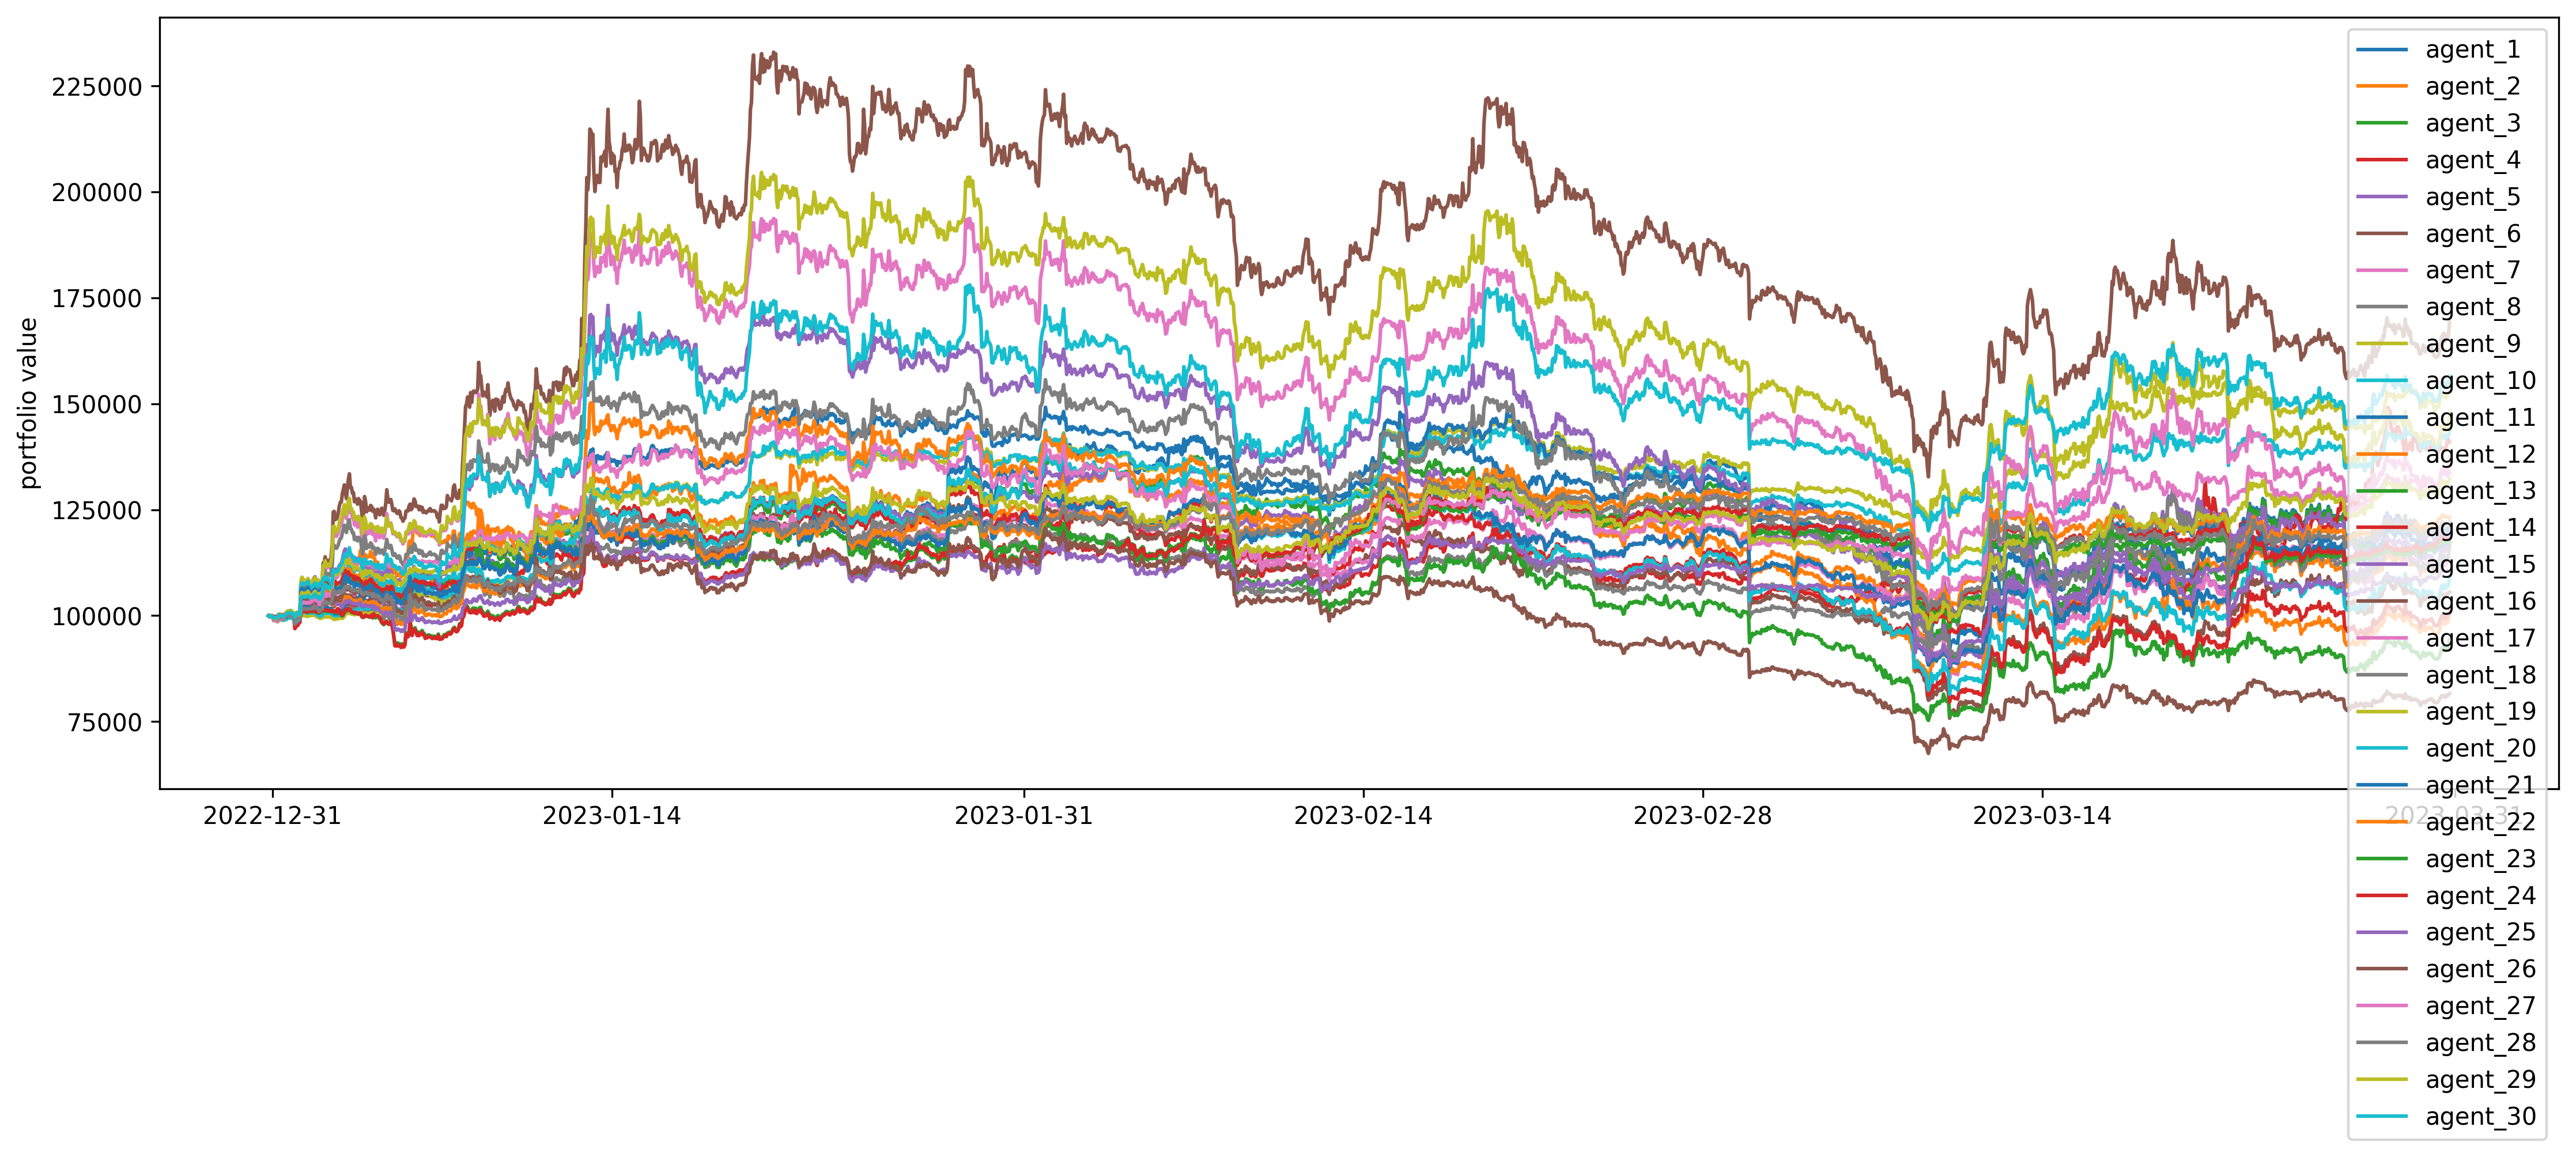

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.dpi"] = 300
plt.figure()

x = df_account_value_ppo["timestamp"]
x = pd.to_datetime(x)
s = 1
for i in final:
    plt.plot(x,i,label=f'agent_{s}')
    s+=1
plt.ylabel("portfolio value")
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig("../../plot/test_plot/ppo_hourly_stack_frame/stack_5_hour_test_default_ppo_act_0.1_seed_42_pnl_reward.png", dpi=300)
plt.show()

In [12]:
df = pd.DataFrame(data = x)
s = 1
for i in final:
    df[f"round_{s}"] = i
    s += 1
df.to_csv("stack_5_hourly_test_default_ppo_act_0.1_seed_42_pnl_reward.csv")